# Modeling & Evaluation: Audio Feature Datasets (TSFEL)
Notebook ini akan:
1. Memuat **dua dataset** hasil ekstraksi fitur: statistik saja & semua fitur.  
2. Melakukan **pelatihan beberapa model** (LogReg, RandomForest, SVC, KNN, GradientBoosting).  
3. Menampilkan **evaluasi & perbandingan akurasi** antar model pada masing-masing dataset.  
4. Menyimpan **model terbaik** dari masing-masing dataset sebagai berkas **`.joblib`** untuk digunakan pada aplikasi pengenalan suara (web statis + backend Python).

> Pastikan file berikut tersedia lebih dulu (direktori relatif ke notebook ini):
> - `./dataset/audio_features_statistical.csv`
> - `./dataset/audio_features_all.csv`


In [12]:

import os
import json
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# Optional: nicer display
pd.set_option('display.max_columns', 200)

DATA_STAT_PATH = './dataset/new/audio_features_statistical.csv'
DATA_ALL_PATH  = './dataset/new/audio_features_all.csv'

MODELS_DIR = './models'
os.makedirs(MODELS_DIR, exist_ok=True)

RANDOM_STATE = 42
TEST_SIZE = 0.2


In [13]:

def load_dataset(path):
    """
    Load dataset, pisahkan fitur dan target.
    - Menghapus kolom non-fitur: filename, nama, target, duration_sec, sr
    - Menggunakan hanya kolom numerik untuk fitur
    - Meng-encode y ('buka'/'tutup') menjadi 0/1 via LabelEncoder
    Mengembalikan: X (DataFrame), y (ndarray), le (LabelEncoder), feature_cols (list)
    """
    df = pd.read_csv(path)
    if 'target' not in df.columns:
        raise ValueError(f"Kolom 'target' tidak ditemukan di {path}. Pastikan ekstraksi menyertakan kolom ini.")
    
    drop_cols = [c for c in ['filename','nama','target','duration_sec','sr'] if c in df.columns]
    X_all = df.drop(columns=drop_cols, errors='ignore')
    # gunakan hanya numerik
    X_num = X_all.select_dtypes(include=[np.number]).copy()
    # simpan nama kolom fitur
    feature_cols = list(X_num.columns)
    
    # label encode y
    le = LabelEncoder()
    y = le.fit_transform(df['target'].astype(str).values)
    
    # catatan: jika dataset kecil, bisa cek kebocoran/konstanta dsb.
    return X_num, y, le, feature_cols, df


In [14]:

def get_models():
    """Kembalikan kumpulan kandidat model (name, estimator)."""
    models = {
        'logreg': LogisticRegression(max_iter=200, n_jobs=None if hasattr(LogisticRegression(), 'n_jobs') else None),
        'rf'    : RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE),
        'svc'   : SVC(kernel='rbf', probability=True, random_state=RANDOM_STATE),
        'knn'   : KNeighborsClassifier(n_neighbors=5),
        'gb'    : GradientBoostingClassifier(random_state=RANDOM_STATE),
    }
    return models


In [15]:

def train_and_evaluate(name_prefix, X, y, le, feature_cols):
    """
    - Train/test split (stratified)
    - Pipeline: SimpleImputer -> StandardScaler -> Model
    - Evaluasi di test set
    - Juga 5-fold CV accuracy (di train set) untuk gambaran stabilitas
    - Kembalikan dict hasil per model & pipeline terbaik
    """
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
    )
    
    models = get_models()
    results = []
    fitted = {}
    
    for name, est in models.items():
        pipe = Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler(with_mean=True, with_std=True)),
            ('clf', est)
        ])
        
        # Cross-val pada train set (accuracy)
        cv_scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring='accuracy')
        
        # Fit dan evaluate di test
        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)
        
        acc = accuracy_score(y_test, y_pred)
        prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted', zero_division=0)
        cm = confusion_matrix(y_test, y_pred)
        
        results.append({
            'dataset': name_prefix,
            'model': name,
            'test_accuracy': acc,
            'test_precision_weighted': prec,
            'test_recall_weighted': rec,
            'test_f1_weighted': f1,
            'cv_acc_mean_train': float(np.mean(cv_scores)),
            'cv_acc_std_train': float(np.std(cv_scores)),
        })
        fitted[name] = {
            'pipeline': pipe,
            'y_test': y_test,
            'y_pred': y_pred,
            'cm': cm
        }
    
    # tentukan best by test_accuracy
    best_row = max(results, key=lambda d: d['test_accuracy'])
    best_name = best_row['model']
    best_pipe = fitted[best_name]['pipeline']
    
    # siapkan paket metadata untuk disimpan bersama model
    model_package = {
        'pipeline': best_pipe,
        'label_encoder': le,
        'feature_columns': feature_cols,
        'target_classes': list(le.classes_)
    }
    
    return pd.DataFrame(results), fitted, (best_name, model_package)


In [16]:

# ===== STATISTICAL DATASET =====
X_stat, y_stat, le_stat, feat_stat, df_stat_raw = load_dataset(DATA_STAT_PATH)
res_stat, fitted_stat, best_stat = train_and_evaluate('statistical', X_stat, y_stat, le_stat, feat_stat)

# ===== ALL-FEATURES DATASET =====
X_all, y_all, le_all, feat_all, df_all_raw = load_dataset(DATA_ALL_PATH)
res_all, fitted_all, best_all = train_and_evaluate('all_features', X_all, y_all, le_all, feat_all)

# Gabungkan hasil untuk perbandingan
comparison_df = pd.concat([res_stat, res_all], ignore_index=True)
comparison_df.sort_values(['dataset','test_accuracy'], ascending=[True, False], inplace=True)
comparison_df.reset_index(drop=True, inplace=True)

comparison_df


,dataset,model,test_accuracy,test_precision_weighted,test_recall_weighted,test_f1_weighted,cv_acc_mean_train,cv_acc_std_train
0,all_features,logreg,0.988095,0.988372,0.988095,0.988094,0.963998,0.007166
1,all_features,rf,0.964286,0.966667,0.964286,0.964240,0.946043,0.024113
2,all_features,svc,0.964286,0.966667,0.964286,0.964240,0.949028,0.026234
3,all_features,knn,0.964286,0.966667,0.964286,0.964240,0.915920,0.033985
4,all_features,gb,0.952381,0.953409,0.952381,0.952354,0.946133,0.032029
5,statistical,svc,0.892857,0.898505,0.892857,0.892476,0.840751,0.023005
6,statistical,rf,0.869048,0.874353,0.869048,0.868582,0.825690,0.054470
7,statistical,logreg,0.845238,0.855102,0.845238,0.844156,0.825961,0.028711
8,statistical,gb,0.821429,0.830612,0.821429,0.820180,0.813795,0.034079
9,statistical,knn,0.797619,0.806122,0.797619,0.796204,0.813885,0.030581


In [17]:
from IPython.display import display

# Simpan tabel perbandingan & tampilkan
os.makedirs('./reports', exist_ok=True)
comp_path = './reports/model_comparison.csv'
comparison_df.to_csv(comp_path, index=False)

display(comparison_df)  # tampilkan tabel langsung di Jupyter
print(f'Perbandingan model disimpan ke: {comp_path}')


,dataset,model,test_accuracy,test_precision_weighted,test_recall_weighted,test_f1_weighted,cv_acc_mean_train,cv_acc_std_train
0,all_features,logreg,0.988095,0.988372,0.988095,0.988094,0.963998,0.007166
1,all_features,rf,0.964286,0.966667,0.964286,0.964240,0.946043,0.024113
2,all_features,svc,0.964286,0.966667,0.964286,0.964240,0.949028,0.026234
3,all_features,knn,0.964286,0.966667,0.964286,0.964240,0.915920,0.033985
4,all_features,gb,0.952381,0.953409,0.952381,0.952354,0.946133,0.032029
5,statistical,svc,0.892857,0.898505,0.892857,0.892476,0.840751,0.023005
6,statistical,rf,0.869048,0.874353,0.869048,0.868582,0.825690,0.054470
7,statistical,logreg,0.845238,0.855102,0.845238,0.844156,0.825961,0.028711
8,statistical,gb,0.821429,0.830612,0.821429,0.820180,0.813795,0.034079
9,statistical,knn,0.797619,0.806122,0.797619,0.796204,0.813885,0.030581


Perbandingan model disimpan ke: ./reports/model_comparison.csv


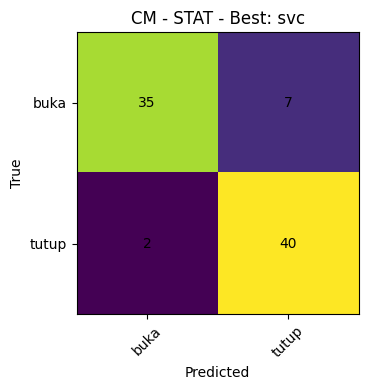

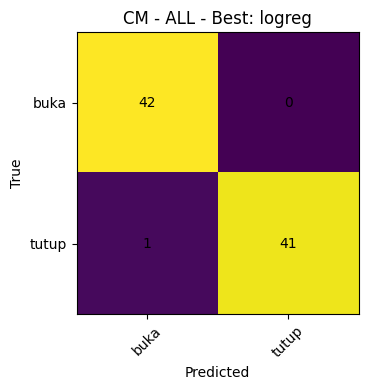

In [18]:

def plot_confusion_matrix(cm, class_names, title):
    fig = plt.figure(figsize=(4,4))
    plt.imshow(cm, interpolation='nearest')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    # Annotate
    thresh = cm.max() / 2. if cm.max() > 0 else 0.5
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",
                     verticalalignment='center')
    plt.tight_layout()
    plt.show()

# Plot untuk model terbaik masing-masing dataset
best_name_stat, best_pkg_stat = best_stat
best_cm_stat = fitted_stat[best_name_stat]['cm']
plot_confusion_matrix(best_cm_stat, best_pkg_stat['target_classes'], f'CM - STAT - Best: {best_name_stat}')

best_name_all, best_pkg_all = best_all
best_cm_all = fitted_all[best_name_all]['cm']
plot_confusion_matrix(best_cm_all, best_pkg_all['target_classes'], f'CM - ALL - Best: {best_name_all}')


In [19]:

# Simpan paket model (pipeline + label encoder + feature columns + kelas)
best_name_stat, best_pkg_stat = best_stat
best_name_all, best_pkg_all = best_all

out_stat_model = os.path.join(MODELS_DIR, 'model_statistical.joblib')
out_all_model  = os.path.join(MODELS_DIR, 'model_all_features.joblib')

joblib.dump(best_pkg_stat, out_stat_model)
joblib.dump(best_pkg_all, out_all_model)

print('Model terbaik (statistical) disimpan ke:', out_stat_model)
print('Model terbaik (all features) disimpan ke:', out_all_model)

# Simpan juga signature kolom untuk referensi cepat (JSON)
with open(os.path.join(MODELS_DIR,'feature_columns_statistical.json'), 'w', encoding='utf-8') as f:
    json.dump(best_pkg_stat['feature_columns'], f, ensure_ascii=False, indent=2)
with open(os.path.join(MODELS_DIR,'feature_columns_all.json'), 'w', encoding='utf-8') as f:
    json.dump(best_pkg_all['feature_columns'], f, ensure_ascii=False, indent=2)

print('Feature column signatures disimpan.')


Model terbaik (statistical) disimpan ke: ./models\model_statistical.joblib
Model terbaik (all features) disimpan ke: ./models\model_all_features.joblib
Feature column signatures disimpan.



## Cara Memakai Model `.joblib` untuk Inference
Contoh kode singkat memuat model dan melakukan prediksi terhadap satu baris fitur (numpy array / DataFrame satu baris) sesuai **urutan kolom fitur** yang tersimpan:


In [20]:

# Contoh pemakaian (offline, setelah model tersimpan):
# import joblib
# import numpy as np
# pkg = joblib.load('./models/model_statistical.joblib')
# pipe = pkg['pipeline']
# classes = pkg['target_classes']
# feature_cols = pkg['feature_columns']
#
# # X_one harus mengikuti urutan 'feature_cols'
# X_one = np.zeros((1, len(feature_cols)), dtype=float)
# y_pred_idx = pipe.predict(X_one)[0]
# y_pred_label = classes[y_pred_idx]
# print('Prediksi:', y_pred_label)
